# Melanoma Classification using CNN

This notebook implements a Convolutional Neural Network (CNN) for melanoma detection using processed images.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
# Set random seeds for reproducibility
from pathlib import Path
import albumentations as A
import random
from sklearn.utils import shuffle
from tensorflow.keras.applications import ResNet50V2
import json
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices()}")

## 1. Load and Prepare Data

We'll load the processed images for melanoma classification.

In [ ]:
# Set paths
base_path = Path('../../../')
processed_dir = base_path / "working" / "processed"
augmented_dir = base_path / "working" / "augmented"
melanoma_dir = processed_dir / "melanoma"
non_melanoma_dir = processed_dir / "non_melanoma"

melanoma_augmented_dir = augmented_dir / "melanoma"
non_melanoma_augmented_dir = augmented_dir / "non_melanoma"

In [ ]:
# Function to load images from directories
def load_images_from_directory(directory, label):
    images = []
    labels = []

    if not os.path.exists(directory):
        print(f"Warning: Directory {directory} does not exist!")
        return images, labels

    for filename in os.listdir(directory):
        if filename.endswith('.jpg'): # Assuming images are JPG, adjust if other formats are present
            img_path = os.path.join(directory, filename)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_COLOR)
                if img is not None:
                    images.append(img)
                    labels.append(label)
                else:
                    print(f"Warning: Could not read image {img_path}. It might be corrupted or not a valid image file.")
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")

    return images, labels


# Load melanoma and non-melanoma images
print("Loading melanoma images...")
melanoma_images, melanoma_labels = load_images_from_directory(melanoma_dir, 1)

print("Loading augmented melanoma images...")
augmented_melanoma_images, augmented_melanoma_labels = load_images_from_directory(
    melanoma_augmented_dir, 1)

# Load non-melanoma images
print("Loading non-melanoma augmented images...")
non_melanoma_augmented_images, non_melanoma_augmented_labels = load_images_from_directory(
    non_melanoma_augmented_dir, 0)

print("Loading non-melanoma images...")
non_melanoma_images, non_melanoma_labels = load_images_from_directory(
    non_melanoma_dir, 0)


In [ ]:
print(f"Loaded {len(melanoma_images)} melanoma images.")
print(f"Loaded {len(augmented_melanoma_images)} augmented melanoma images.")
print(f"Loaded {len(non_melanoma_images)} non-melanoma images.")
print(f"Loaded {len(non_melanoma_augmented_images)} augmented non-melanoma images.")
print(f"\nTotal Melanoma images: {len(melanoma_images) + len(augmented_melanoma_images)}")
print(f"Total Non-Melanoma images: {len(non_melanoma_images) + len(non_melanoma_augmented_images)}")

In [ ]:
# Combine datasets with balanced classes
# Take all melanoma images and equal number of non-melanoma images
X = np.array(melanoma_images + augmented_melanoma_images + non_melanoma_images[:10157] + non_melanoma_augmented_images[:10157])
y = np.array(melanoma_labels + augmented_melanoma_labels + non_melanoma_labels[:10157] + non_melanoma_augmented_labels[:10157])


# Print dataset information
print(f"Dataset loaded: {X.shape} images")

In [ ]:
# Split data into training, validation, and test sets
# First split: 80% training+validation, 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: 80% training, 20% validation (from the training+validation set)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape} images")
print(f"Validation set: {X_val.shape} images")
print(f"Test set: {X_test.shape[0]} images")

# Check class distribution in each set
print(f"Training set - Melanoma: {np.sum(y_train == 1)}, Non-melanoma: {np.sum(y_train == 0)}")
print(f"Validation set - Melanoma: {np.sum(y_val == 1)}, Non-melanoma: {np.sum(y_val == 0)}")
print(f"Test set - Melanoma: {np.sum(y_test == 1)}, Non-melanoma: {np.sum(y_test == 0)}")

In [ ]:
IMG_WIDTH = 224  # Ensure this is defined, from your model cell
IMG_HEIGHT = 224  # Ensure this is defined, from your model cell
IMAGE_SIZE = (IMG_HEIGHT, IMG_WIDTH)
BATCH_SIZE = 32  # Ensure this is defined, from your training cell


print("Loading images using tf.keras.utils.image_dataset_from_directory...")

if not processed_dir.exists():
    raise FileNotFoundError(f"Processed directory not found: {processed_dir}")
if not augmented_dir.exists():
    raise FileNotFoundError(f"Augmented directory not found: {augmented_dir}")

try:
    processed_ds = tf.keras.utils.image_dataset_from_directory(
        processed_dir,
        labels="inferred",
        label_mode="binary",  # For binary classification (0.0 or 1.0)
        class_names=[
            "non_melanoma",
            "melanoma",
        ],  # Ensures 0 for non_melanoma, 1 for melanoma
        image_size=IMAGE_SIZE,
        interpolation="nearest",
        batch_size=None,  # Load unbatched first, batch later
        shuffle=False,  # Shuffle after combining
    )
    print(f"Class names for processed_ds: {processed_ds.class_names}")

    augmented_ds = tf.keras.utils.image_dataset_from_directory(
        augmented_dir,
        labels="inferred",
        label_mode="binary",
        class_names=["non_melanoma", "melanoma"],
        image_size=IMAGE_SIZE,
        interpolation="nearest",
        batch_size=None,  # Load unbatched first, batch later
        shuffle=False,
    )
    print(f"Class names for augmented_ds: {augmented_ds.class_names}")

    full_ds = processed_ds.concatenate(augmented_ds)
    print("Combined processed and augmented datasets.")

    num_total_samples = 0
    for _ in full_ds:
        num_total_samples += 1
    print(f"Total samples in combined dataset: {num_total_samples}")

    if num_total_samples == 0:
        raise ValueError(
            "No data loaded. Check your directories and image_dataset_from_directory calls."
        )

    SHUFFLE_BUFFER_SIZE = num_total_samples
    full_ds = full_ds.shuffle(
        buffer_size=SHUFFLE_BUFFER_SIZE, reshuffle_each_iteration=True
    )
    print(f"Shuffling dataset with buffer size: {SHUFFLE_BUFFER_SIZE}")

    train_size = int(0.64 * num_total_samples)
    val_size = int(0.16 * num_total_samples)
    # test_size = num_total_samples - train_size - val_size # The rest is test

    train_ds = full_ds.take(train_size)
    val_ds = full_ds.skip(train_size).take(val_size)
    test_ds = full_ds.skip(train_size + val_size)

    print(f"Training set size: {train_size} samples")
    print(f"Validation set size: {val_size} samples")
    # To get test_size accurately after take/skip:
    test_samples_count = 0
    for _ in test_ds:  # Iterate to count elements in test_ds
        test_samples_count += 1
    print(f"Test set size: {test_samples_count} samples")

    # Batch and prefetch for performance
    # Normalization: ResNet50V2 expects inputs in [-1, 1] or [0, 1] depending on `preprocess_input`
    # or how you handle it. image_dataset_from_directory loads pixels in [0, 255].
    # You should add a normalization step.
    def normalize_img(image, label):
        # Rescale to [0,1] - adjust if your model/ResNet50V2 preprocess_input expects different range
        return tf.cast(image, tf.float32) / 255.0, label

    train_ds = (
        train_ds.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(BATCH_SIZE)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )
    val_ds = (
        val_ds.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(BATCH_SIZE)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )
    test_ds = (
        test_ds.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(BATCH_SIZE)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

    print("Training, validation, and test datasets created, batched, and prefetched.")

    # Inspect a batch (optional)
    for images, labels in train_ds.take(1):
        print(
            "Images shape in a batch:", images.shape
        )  # (BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3)
        print(
            "Labels shape in a batch:", labels.shape
        )  # (BATCH_SIZE, 1) for label_mode='binary'
        print("Sample labels:", labels.numpy()[:5])

except Exception as e:
    print(f"An error occurred during data loading with tf.data: {e}")
    print(
        "Please ensure your directories are structured correctly (e.g., processed_dir/melanoma, processed_dir/non_melanoma)."
    )
    train_ds, val_ds, test_ds = None, None, None  # Fallback

In [ ]:
class_weight = {0: np.float64(1.2165908505707665), 1: np.float64(2.1833795440542207)}

## 2. Build CNN Model

We'll create a CNN model architecture suitable for melanoma classification.

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_CHANNELS = 3
NUM_CLASSES = 1


def build_cnn_model(input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)):
    base_model = ResNet50V2(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        pooling=None,  # We'll add our own pooling layer
    )
    base_model.trainable = False  # Freeze the base model
    # Compile model
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
    outputs = tf.keras.layers.Dense(
        NUM_CLASSES, activation="sigmoid", name="classifier"
    )(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="Melanoma_ResNet50V2")
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.AUC(name="auc"),
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),  # Recall is Sensitivity
        ],
    )
    return model


# Build the model
model = build_cnn_model()
model.summary()

In [ ]:
# Set up callbacks for training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6),
    ModelCheckpoint('../working/melanoma_model.h5', monitor='val_auc', mode='max', save_best_only=True, verbose=1)
]


In [ ]:
X_train.shape

In [8]:
# Train the model
batch_size = 32
epochs = 20

history = model.fit(
    train_ds,  # Already batched
    epochs=epochs,
    validation_data=val_ds,  # Already batched
    callbacks=callbacks,
    class_weight=class_weight,  # Use the recalculated class_weight
    verbose=1,
)

1134/1134 ━━━━━━━━━━━━━━━━━━━━ 0s 868ms/step - accuracy: 0.5828 - auc: 0.6389 - loss: 1.0504 - precision: 0.4487 - recall: 0.6449
Epoch 1: val_auc improved from -inf to 0.77479, saving model to ../working/melanoma_model.h5


1134/1134 ━━━━━━━━━━━━━━━━━━━━ 1159s 1s/step - accuracy: 0.5828 - auc: 0.6390 - loss: 1.0503 - precision: 0.4487 - recall: 0.6449 - val_accuracy: 0.7141 - val_auc: 0.7748 - val_loss: 0.5542 - val_precision: 0.5946 - val_recall: 0.6386 - learning_rate: 1.0000e-04
Epoch 2/20
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.7105 - auc: 0.7837 - loss: 0.8720 - precision: 0.5813 - recall: 0.6887
Epoch 2: val_auc improved from 0.77479 to 0.80892, saving model to ../working/melanoma_model.h5


1134/1134 ━━━━━━━━━━━━━━━━━━━━ 714s 620ms/step - accuracy: 0.7105 - auc: 0.7837 - loss: 0.8720 - precision: 0.5813 - recall: 0.6887 - val_accuracy: 0.7385 - val_auc: 0.8089 - val_loss: 0.5231 - val_precision: 0.6194 - val_recall: 0.6944 - learning_rate: 1.0000e-04
Epoch 3/20
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.7285 - auc: 0.8030 - loss: 0.8408 - precision: 0.6035 - recall: 0.7088
Epoch 3: val_auc improved from 0.80892 to 0.81195, saving model to ../working/melanoma_model.h5


1134/1134 ━━━━━━━━━━━━━━━━━━━━ 712s 620ms/step - accuracy: 0.7285 - auc: 0.8031 - loss: 0.8408 - precision: 0.6035 - recall: 0.7088 - val_accuracy: 0.7389 - val_auc: 0.8120 - val_loss: 0.5259 - val_precision: 0.6094 - val_recall: 0.7190 - learning_rate: 1.0000e-04
Epoch 4/20
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step - accuracy: 0.7394 - auc: 0.8133 - loss: 0.8228 - precision: 0.6143 - recall: 0.7230
Epoch 4: val_auc improved from 0.81195 to 0.81389, saving model to ../working/melanoma_model.h5


1134/1134 ━━━━━━━━━━━━━━━━━━━━ 713s 621ms/step - accuracy: 0.7394 - auc: 0.8133 - loss: 0.8228 - precision: 0.6143 - recall: 0.7230 - val_accuracy: 0.7436 - val_auc: 0.8139 - val_loss: 0.5108 - val_precision: 0.6396 - val_recall: 0.6742 - learning_rate: 1.0000e-04
Epoch 5/20
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.7414 - auc: 0.8207 - loss: 0.8073 - precision: 0.6177 - recall: 0.7275
Epoch 5: val_auc improved from 0.81389 to 0.82074, saving model to ../working/melanoma_model.h5


1134/1134 ━━━━━━━━━━━━━━━━━━━━ 713s 620ms/step - accuracy: 0.7414 - auc: 0.8207 - loss: 0.8073 - precision: 0.6177 - recall: 0.7275 - val_accuracy: 0.7444 - val_auc: 0.8207 - val_loss: 0.5104 - val_precision: 0.6293 - val_recall: 0.7113 - learning_rate: 1.0000e-04
Epoch 6/20
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 0s 821ms/step - accuracy: 0.7481 - auc: 0.8276 - loss: 0.7934 - precision: 0.6239 - recall: 0.7360
Epoch 6: val_auc improved from 0.82074 to 0.82913, saving model to ../working/melanoma_model.h5


1134/1134 ━━━━━━━━━━━━━━━━━━━━ 1179s 1s/step - accuracy: 0.7481 - auc: 0.8276 - loss: 0.7934 - precision: 0.6239 - recall: 0.7360 - val_accuracy: 0.7427 - val_auc: 0.8291 - val_loss: 0.5098 - val_precision: 0.6235 - val_recall: 0.7458 - learning_rate: 1.0000e-04
Epoch 7/20
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7444 - auc: 0.8264 - loss: 0.7975 - precision: 0.6232 - recall: 0.7361
Epoch 7: val_auc improved from 0.82913 to 0.83892, saving model to ../working/melanoma_model.h5


1134/1134 ━━━━━━━━━━━━━━━━━━━━ 1518s 1s/step - accuracy: 0.7444 - auc: 0.8264 - loss: 0.7975 - precision: 0.6232 - recall: 0.7361 - val_accuracy: 0.7591 - val_auc: 0.8389 - val_loss: 0.4965 - val_precision: 0.6501 - val_recall: 0.7499 - learning_rate: 1.0000e-04
Epoch 8/20
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.7481 - auc: 0.8305 - loss: 0.7834 - precision: 0.6195 - recall: 0.7331
Epoch 8: val_auc did not improve from 0.83892
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 1327s 1s/step - accuracy: 0.7481 - auc: 0.8305 - loss: 0.7834 - precision: 0.6195 - recall: 0.7331 - val_accuracy: 0.7602 - val_auc: 0.8377 - val_loss: 0.4979 - val_precision: 0.6460 - val_recall: 0.7535 - learning_rate: 1.0000e-04
Epoch 9/20
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.7520 - auc: 0.8342 - loss: 0.7780 - precision: 0.6268 - recall: 0.7368
Epoch 9: val_auc did not improve from 0.83892
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 787s 673ms/step - accuracy: 0.7520 - auc: 0.8342 - loss: 0.7780 - pre

1134/1134 ━━━━━━━━━━━━━━━━━━━━ 717s 622ms/step - accuracy: 0.7592 - auc: 0.8400 - loss: 0.7690 - precision: 0.6381 - recall: 0.7464 - val_accuracy: 0.7506 - val_auc: 0.8395 - val_loss: 0.5025 - val_precision: 0.6204 - val_recall: 0.7707 - learning_rate: 1.0000e-04
Epoch 11/20
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.7525 - auc: 0.8364 - loss: 0.7763 - precision: 0.6317 - recall: 0.7415
Epoch 11: val_auc did not improve from 0.83953
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 718s 625ms/step - accuracy: 0.7525 - auc: 0.8364 - loss: 0.7763 - precision: 0.6317 - recall: 0.7415 - val_accuracy: 0.7560 - val_auc: 0.8379 - val_loss: 0.4989 - val_precision: 0.6288 - val_recall: 0.7528 - learning_rate: 1.0000e-04
Epoch 12/20
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.7558 - auc: 0.8395 - loss: 0.7715 - precision: 0.6371 - recall: 0.7457
Epoch 12: val_auc improved from 0.83953 to 0.84306, saving model to ../working/melanoma_model.h5


1134/1134 ━━━━━━━━━━━━━━━━━━━━ 714s 621ms/step - accuracy: 0.7558 - auc: 0.8395 - loss: 0.7715 - precision: 0.6371 - recall: 0.7457 - val_accuracy: 0.7587 - val_auc: 0.8431 - val_loss: 0.4863 - val_precision: 0.6431 - val_recall: 0.7414 - learning_rate: 1.0000e-04
Epoch 13/20
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - accuracy: 0.7555 - auc: 0.8392 - loss: 0.7680 - precision: 0.6321 - recall: 0.7437
Epoch 13: val_auc improved from 0.84306 to 0.84594, saving model to ../working/melanoma_model.h5


1134/1134 ━━━━━━━━━━━━━━━━━━━━ 921s 804ms/step - accuracy: 0.7555 - auc: 0.8392 - loss: 0.7680 - precision: 0.6321 - recall: 0.7437 - val_accuracy: 0.7592 - val_auc: 0.8459 - val_loss: 0.4882 - val_precision: 0.6423 - val_recall: 0.7651 - learning_rate: 1.0000e-04
Epoch 14/20
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 0s 795ms/step - accuracy: 0.7604 - auc: 0.8441 - loss: 0.7600 - precision: 0.6383 - recall: 0.7522
Epoch 14: val_auc improved from 0.84594 to 0.84605, saving model to ../working/melanoma_model.h5


1134/1134 ━━━━━━━━━━━━━━━━━━━━ 1104s 956ms/step - accuracy: 0.7604 - auc: 0.8441 - loss: 0.7600 - precision: 0.6383 - recall: 0.7522 - val_accuracy: 0.7608 - val_auc: 0.8461 - val_loss: 0.4881 - val_precision: 0.6337 - val_recall: 0.7554 - learning_rate: 1.0000e-04
Epoch 15/20
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - accuracy: 0.7658 - auc: 0.8457 - loss: 0.7566 - precision: 0.6460 - recall: 0.7521
Epoch 15: val_auc did not improve from 0.84605
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 1185s 1s/step - accuracy: 0.7658 - auc: 0.8457 - loss: 0.7566 - precision: 0.6460 - recall: 0.7521 - val_accuracy: 0.7586 - val_auc: 0.8429 - val_loss: 0.4882 - val_precision: 0.6369 - val_recall: 0.7478 - learning_rate: 1.0000e-04
Epoch 16/20
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 0s 830ms/step - accuracy: 0.7598 - auc: 0.8435 - loss: 0.7632 - precision: 0.6428 - recall: 0.7571
Epoch 16: val_auc improved from 0.84605 to 0.84893, saving model to ../working/melanoma_model.h5


1134/1134 ━━━━━━━━━━━━━━━━━━━━ 1262s 1s/step - accuracy: 0.7598 - auc: 0.8435 - loss: 0.7632 - precision: 0.6428 - recall: 0.7571 - val_accuracy: 0.7610 - val_auc: 0.8489 - val_loss: 0.4816 - val_precision: 0.6387 - val_recall: 0.7607 - learning_rate: 1.0000e-04
Epoch 17/20
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.7652 - auc: 0.8492 - loss: 0.7506 - precision: 0.6485 - recall: 0.7618
Epoch 17: val_auc improved from 0.84893 to 0.85018, saving model to ../working/melanoma_model.h5


1134/1134 ━━━━━━━━━━━━━━━━━━━━ 1109s 960ms/step - accuracy: 0.7652 - auc: 0.8492 - loss: 0.7506 - precision: 0.6485 - recall: 0.7618 - val_accuracy: 0.7704 - val_auc: 0.8502 - val_loss: 0.4754 - val_precision: 0.6565 - val_recall: 0.7430 - learning_rate: 1.0000e-04
Epoch 18/20
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.7600 - auc: 0.8455 - loss: 0.7579 - precision: 0.6413 - recall: 0.7523
Epoch 18: val_auc did not improve from 0.85018
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 980s 851ms/step - accuracy: 0.7600 - auc: 0.8455 - loss: 0.7579 - precision: 0.6413 - recall: 0.7523 - val_accuracy: 0.7631 - val_auc: 0.8455 - val_loss: 0.4870 - val_precision: 0.6483 - val_recall: 0.7569 - learning_rate: 1.0000e-04
Epoch 19/20
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - accuracy: 0.7632 - auc: 0.8471 - loss: 0.7534 - precision: 0.6446 - recall: 0.7506
Epoch 19: val_auc improved from 0.85018 to 0.85107, saving model to ../working/melanoma_model.h5


1134/1134 ━━━━━━━━━━━━━━━━━━━━ 1025s 887ms/step - accuracy: 0.7632 - auc: 0.8471 - loss: 0.7534 - precision: 0.6446 - recall: 0.7506 - val_accuracy: 0.7611 - val_auc: 0.8511 - val_loss: 0.4851 - val_precision: 0.6319 - val_recall: 0.7734 - learning_rate: 1.0000e-04
Epoch 20/20
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 0s 614ms/step - accuracy: 0.7644 - auc: 0.8503 - loss: 0.7474 - precision: 0.6444 - recall: 0.7610
Epoch 20: val_auc did not improve from 0.85107
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 923s 800ms/step - accuracy: 0.7644 - auc: 0.8503 - loss: 0.7474 - precision: 0.6444 - recall: 0.7610 - val_accuracy: 0.7526 - val_auc: 0.8431 - val_loss: 0.4953 - val_precision: 0.6214 - val_recall: 0.7708 - learning_rate: 1.0000e-04


## 3. Evaluate Model Performance

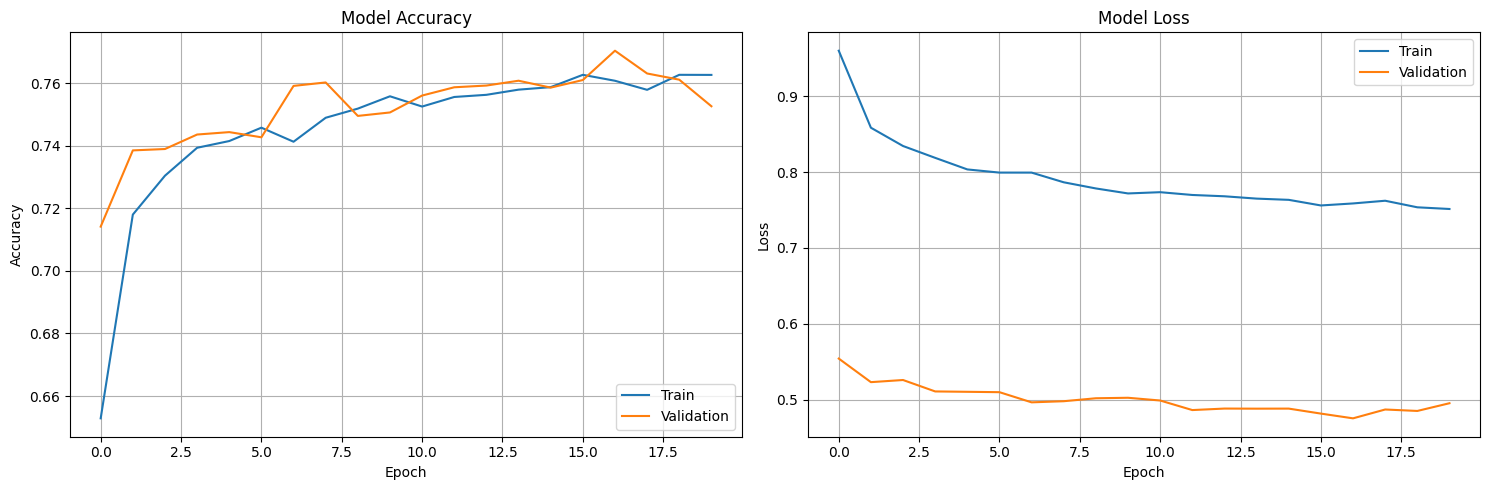

In [9]:
# Plot training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history["accuracy"])
    ax1.plot(history.history["val_accuracy"])
    ax1.set_title("Model Accuracy")
    ax1.set_ylabel("Accuracy")
    ax1.set_xlabel("Epoch")
    ax1.legend(["Train", "Validation"], loc="lower right")
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history["loss"])
    ax2.plot(history.history["val_loss"])
    ax2.set_title("Model Loss")
    ax2.set_ylabel("Loss")
    ax2.set_xlabel("Epoch")
    ax2.legend(["Train", "Validation"], loc="upper right")
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


# Plot training history
plot_training_history(history)

In [ ]:
print("Evaluating on test set using test_ds...")
results = model.evaluate(test_ds, verbose=0)
metric_names = model.metrics_names
results_dict = dict(zip(metric_names, results))

test_loss = results_dict.get("loss", 0.0)
test_acc = results_dict.get("accuracy", 0.0)
test_auc = results_dict.get("auc", 0.0)
test_precision = results_dict.get("precision", 0.0)
test_recall = results_dict.get("recall", 0.0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall (Sensitivity): {test_recall:.4f}")

# Make predictions on test set
print("Making predictions on test set using test_ds...")
y_pred_proba_list = []
y_true_test_list = []
for images_batch, labels_batch in test_ds:
    y_pred_proba_list.append(model.predict_on_batch(images_batch))
    y_true_test_list.append(labels_batch.numpy())

y_pred_proba = np.concatenate(y_pred_proba_list, axis=0)
y_true_test = np.concatenate(
    y_true_test_list, axis=0
).flatten()  # Flatten if labels are (batch,1)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Print classification report
print("\nClassification Report:")
print(
    classification_report(
        y_true_test, y_pred, target_names=["Non-Melanoma", "Melanoma"]
    )
)

# Print confusion matrix
conf_matrix = confusion_matrix(y_true_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)


Evaluating on test set using test_ds...
Test Loss: 0.4788
Test Accuracy: 0.0000
Test AUC: 0.0000
Test Precision: 0.0000
Test Recall (Sensitivity): 0.0000
Making predictions on test set using test_ds...

Classification Report:
              precision    recall  f1-score   support

Non-Melanoma       0.85      0.78      0.81      7268
    Melanoma       0.65      0.75      0.70      4073

    accuracy                           0.77     11341
   macro avg       0.75      0.76      0.75     11341
weighted avg       0.78      0.77      0.77     11341


Confusion Matrix:
[[5639 1629]
 [1031 3042]]


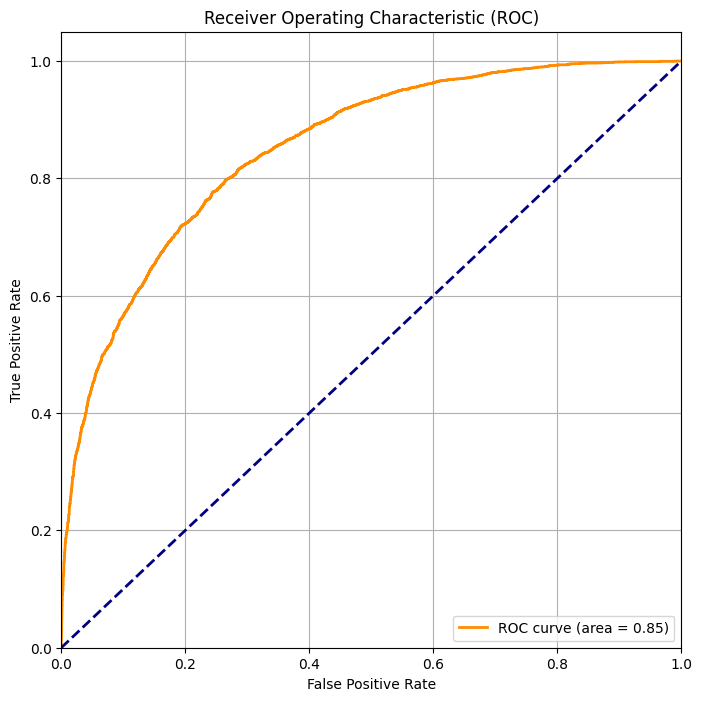

In [14]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_true_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [15]:
# Visualize some predictions
def visualize_predictions(X, y_true, y_pred, y_pred_proba, num_samples=8):
    # Select random samples
    indices = np.random.choice(
        range(len(y_true)), min(num_samples, len(y_true)), replace=False
    )

    # Create figure
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()

    for i, idx in enumerate(indices):
        if i >= num_samples:
            break

        # Get image and labels
        img = X[idx]
        true_label = y_true[idx]
        pred_label = y_pred[idx]
        prob = y_pred_proba[idx][0]

        # Determine text color based on prediction correctness
        color = "green" if true_label == pred_label else "red"

        # Plot image
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(
            f"True: {'Melanoma' if true_label == 1 else 'Non-Melanoma'}\n"
            + f"Pred: {'Melanoma' if pred_label == 1 else 'Non-Melanoma'} ({prob:.3f})",
            color=color,
        )
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


# Visualize predictions
visualize_predictions(X_test, y_true_test, y_pred, y_pred_proba)

NameError: name 'X_test' is not defined

## 4. Save Model and Results

In [16]:
# Save model
model_path = "../working/melanoma_revisited_final_2.h5"
model.save(model_path)
print(f"Model saved to {model_path}")

# Save test results
results = {
    "accuracy": float(test_acc),
    "auc": float(test_auc),
    "loss": float(test_loss),
}

with open("../working/model_results.json", "w") as f:
    json.dump(results, f)
print("Results saved to ../working/model_results.json")

Model saved to ../working/melanoma_revisited_final_2.h5
Results saved to ../working/model_results.json
